## 首先， BERT 很耗時，要先

執行階段 -> 變更執行類型 -> 開啟GPU開啟GPU

看完這篇再去調參數:
https://mlfromscratch.com/activation-functions-explained/#/

In [ ]:
# kill the RAM
# !kill -9 -1

## 此檔案用Leo iss帳號 執行，因為GPU不足

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## 先確定確認環境是否支援GPU 

import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# ### 為 pytorch 設定使用 GPU 
# 沒關係，我們用CPU跑torch
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('有 %d 個 GPU 可使用。' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('沒有 GPU 可使用，改使用 CPU。')
    device = torch.device("cpu")

有 1 個 GPU 可使用。
GPU: Tesla T4


## 沒開GPU/沒GPU用/GPU 扣打用完，下面train data改小一點，不然會等到畢業

In [4]:
!pip install -q -U "tensorflow-text==2.8.*" #  # 安裝指定版本，不然colab會裝最新版，如果之後沒有向下支援會不能跑

     |████████████████████████████████| 4.9 MB 7.9 MB/s 


用AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [5]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 9.4 MB/s 
     |████████████████████████████████| 352 kB 55.1 MB/s 
     |████████████████████████████████| 1.2 MB 52.6 MB/s 
     |████████████████████████████████| 596 kB 66.3 MB/s 
     |████████████████████████████████| 237 kB 79.7 MB/s 
     |████████████████████████████████| 47.8 MB 50 kB/s 
     |████████████████████████████████| 99 kB 8.1 MB/s 
     |████████████████████████████████| 92 kB 11.5 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 1.1 MB 57.3 MB/s 


In [6]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## 直接指定中文的預先處理程序(pre-process)
- ps: 要其他的版本去另一個ipynb找，我有寫一個可以抓版本的介面

## Key的七個秘密:


1.   input_mask: 輸入的mask，1代表是正常輸入，0代表的是padding的輸入
2.   segment_ids: 輸入的0：代表句子A或者padding句子，1代表句子B
3.   masked_lm_positions：我們mask的token的位置
4. masked_lm_ids：我們mask的token的對應id
5. masked_lm_weights：我們mask的token的權重，1代表是真實mask的，0代表的是padding的mask
6. next_sentence_labels：句子A和B是否是上下句 (這個新的Paper指出很廢，沒啥用)
7. input_ids: 輸入的token對應的id

Test1

In [7]:
tfhub_handle_preprocess = "https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3"
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

# text_test = ['他只是個孩子啊','我的心碎成了很多片，每一片都愛上不同的人']
text_test = ['我只是個孩子啊','我的心碎成了很多片，每一片都愛上不同的人']

text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}') # Keys對應了七個屬性，這邊列印出來跟classification有關的，其他四個屬性我沒用過，要查Hub裡面的Advance topics
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}') # 最大長度，我們這個模型最多吃128 -3 = 125個長度的句子
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}') # [101] 是 [CLS]
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}') # 1就是有字，0是我們padding 的0
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}') # 不知道這是洨

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (2, 128)
Word Ids   : [ 101 2769 1372 3221  943 2111 2094 1557  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Test2

In [8]:
text_test = ['他只是個孩子啊','我的心碎成了很多片，每一片都愛上不同的人']
#text_test = ['我只是個孩子啊','我的心碎成了很多片，每一片都扎在你的腳底']

text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}') # Keys對應了七個屬性，這邊列印出來跟classification有關的，其他四個屬性我沒用過，要查Hub裡面的Advance topics
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}') # 最大長度，我們這個模型最多吃128 -3 = 125個長度的句子
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}') # [101] 是 [CLS] [102]是[SEP]
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (2, 128)
Word Ids   : [ 101  800 1372 3221  943 2111 2094 1557  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## 直接指定中文的encoder

bert_zh_L-12_H-768_A-12

看檔名: 768維度，所以我們不是用large(1024還是1048維度)的

In [9]:
tfhub_handle_encoder = "https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4"
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)
print(f'Keys       : {list(bert_results.keys())}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')

print(f'\n\n-----------------Sequence Outputs 【batch_size, seq_length, hidden_size】:\n\n')

# 這是訓練後每個token的詞向量。
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')

print(f'\n\n-----------------Pooled_output 【batch_size, hidden_size】:\n\n')
# 每個sequence第一個位置CLS的向量輸出，用於分類任務。
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Keys       : ['default', 'pooled_output', 'encoder_outputs', 'sequence_output']
Pooled Outputs Shape:(2, 768)
Pooled Outputs Values:[ 0.9951877   0.9999987   0.75895447  0.9927028   0.9609237   0.8980626
 -0.9664992  -0.8147569   0.992256   -0.9955092   0.9999951  -0.03696701]


-----------------Sequence Outputs 【batch_size, seq_length, hidden_size】:


Sequence Outputs Shape:(2, 128, 768)


-----------------Pooled_output 【batch_size, hidden_size】:


Sequence Outputs Values:[[ 0.26301262  0.59707963  0.22219351 ...  1.0153513   0.13897443
  -0.00661813]
 [ 1.2074199   0.61525524  0.7530454  ...  0.1953829   0.26875502
   0.606423  ]
 [ 1.285511   -0.06451766  0.01800819 ...  0.81091714  0.5056504
   0.21488908]
 ...
 [ 0.3440423   0.73617125 -0.01728487 ... -0.06457531 -0.53578055
  -0.10931359]
 [ 0.28242332  0.7280945  -0.0751037  ...  0.00773475 -0.59589773
  -0.18359847]
 [ 0.1683045   0.5671126  -0.10745365 ...  0.06260364 -0.69228685
  -0.15895809]]


# 環境準備

In [10]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

import tensorflow as tf
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

## encoder 和 preprocess指定

In [11]:
tfhub_handle_preprocess = "https://hub.tensorflow.google.cn/tensorflow/bert_zh_preprocess/3"
tfhub_handle_encoder = "https://hub.tensorflow.google.cn/tensorflow/bert_zh_L-12_H-768_A-12/4"
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

## 準備資料集

因為是在Colab上傳檔案的形式。所以在本地壓縮成一個zip包,上傳到Colab後做解壓。

(因為我只找得到簡體的有label的情緒分資料，這邊應該換成繁體的)
我這邊用https://github.com/lunarwhite/Chinese-corpus-sentiment-data-analysis
的資料集，zip檔有上傳到資料夾了

In [12]:
import zipfile
from pathlib import Path
# zipfile_path = "/content/drive/MyDrive/NTHU/TextMining/Text Mining Team Project/Code/Leo's workplace/data source/datanew.zip" 
# zipfile_path = "/content/drive/MyDrive/Text Mining Team Project/Code/Leo's workplace/data source/datanew.zip" 
zipfile_path = "/content/drive/Shareddrives/Text Mining/DataSource/datanew.zip"
zFile = zipfile.ZipFile(zipfile_path ,"r")
for fileM in zFile.namelist(): 
        zFile.extract(fileM, "datanew")
# zFile.close();

## 把Tuning 的參數拉出來設定

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 110078509

拆出Train data

In [14]:
datanew_path = "/content/datanew/datanew"

In [15]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    datanew_path,
    batch_size=batch_size,
    validation_split=0.2, # 從pos, neg中取出80% 當成train data
    subset='training',
    seed=seed)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.


In [16]:
class_names = raw_train_ds.class_names
print(class_names) # ['neg', 'pos']
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE) # 邊拉檔案邊跑模型，不用等全部載完才跑

['neg', 'pos']


### Validation set

In [17]:
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    datanew_path,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)
## 問題: 為何不會拉到training data? 可4Google turtrial都這樣寫捏

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) # Same, we work smart

Found 4000 files belonging to 2 classes.
Using 800 files for validation.


## dataset 長這副德性


In [20]:
for text_batch, label_batch in train_ds.take(1):
  # print(text_batch)
  for i in range(3):
    # print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    # print(f'Label : {label} ({class_names[label]})')

## Define Model

### tf.layers.dense()

- inputs：輸入該網絡層的數據
- activation：激活函數，即神經網絡的非線性變化，用sigmoid
  - Sigmoid:
  1. 有梯度消失問題
  2. 值在0-1間
  3. 收斂有夠慢

優化器選擇adamw: 

- Why: 用adamw的原因是要強化收斂速度，但是要調參。
- What: 權重衰減與 L2 正則化(減少overfitting)

- 可以用SGD+ Momentum 取代
- 為何不用gelu?

參考: https://zhuanlan.zhihu.com/p/39543160

In [21]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.5)(net)

  net = tf.keras.layers.Dense(6, activation='softmax', name='classifier')(net)  
  # 改成softmax邏輯回歸比較好，這樣最後一層的機率總和才會是1 來取出非互斥類別0/1值
  # 搭配softmax必須使用Cross Entropy當loss function
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
print(num_train_steps)
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                      num_train_steps=num_train_steps,
                      num_warmup_steps=num_warmup_steps,
                      optimizer_type='adamw')

loss = tf.keras.losses.SparseCategoricalCrossentropy()
# 搭配softmax必須使用Cross Entropy當loss function: 評估兩個機率分配(distribution) 有多接近，越遠entrophy 越靠近1


metrics = tf.metrics.SparseCategoricalAccuracy()
classifier_model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

1000


### 訓練模型

In [23]:
test_epoch = 10

history = classifier_model.fit(x=train_ds,
                 validation_data=val_ds,
                 epochs=test_epoch)

Epoch 1/10
100/100 [==============================] - 97s 972ms/step - loss: 1.0647 - sparse_categorical_accuracy: 0.6384 - val_loss: 0.2871 - val_sparse_categorical_accuracy: 0.8888
Epoch 2/10
100/100 [==============================] - 98s 980ms/step - loss: 0.2993 - sparse_categorical_accuracy: 0.9019 - val_loss: 0.2989 - val_sparse_categorical_accuracy: 0.8838
Epoch 3/10
100/100 [==============================] - 101s 1s/step - loss: 0.1879 - sparse_categorical_accuracy: 0.9463 - val_loss: 0.3490 - val_sparse_categorical_accuracy: 0.8888
Epoch 4/10
100/100 [==============================] - 100s 997ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.9706 - val_loss: 0.4715 - val_sparse_categorical_accuracy: 0.9025
Epoch 5/10
100/100 [==============================] - 100s 1s/step - loss: 0.0981 - sparse_categorical_accuracy: 0.9753 - val_loss: 0.6104 - val_sparse_categorical_accuracy: 0.8938
Epoch 6/10
100/100 [==============================] - 99s 987ms/step - loss: 0.0433 - sp

History 資料儲存
該資料為model

In [24]:
model_path = "/content/drive/Shareddrives/Text Mining/DataSource/bertmodel_parameter/"

In [25]:
# 存成csv

# hist_csv_file = 'history.csv'
# with open(model_path + 'history.csv', mode='w') as f:
#     history.to_csv(f)

AttributeError: ignored

## 存model起來，不然每次都要訓練，GPU不夠

In [26]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Load in the model

In [30]:
# # 從 HDF5 檔案中載入模型
# model_pwd = "/content/drive/Shareddrives/Text Mining/DataSource/bertmodel_parameter/history.csv"
# model = tf.contrib.keras.models.load_model(model_pwd)

# # # # 驗證模型
# # score = model.evaluate(x_test, y_test, verbose=0)

# # # 輸出結果
# # print('Test loss:', score[0])
# # print('Test accuracy:', score[1])

AttributeError: ignored

## 預測資料

In [32]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : class: {class_names[np.argmax(results[i])] }'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

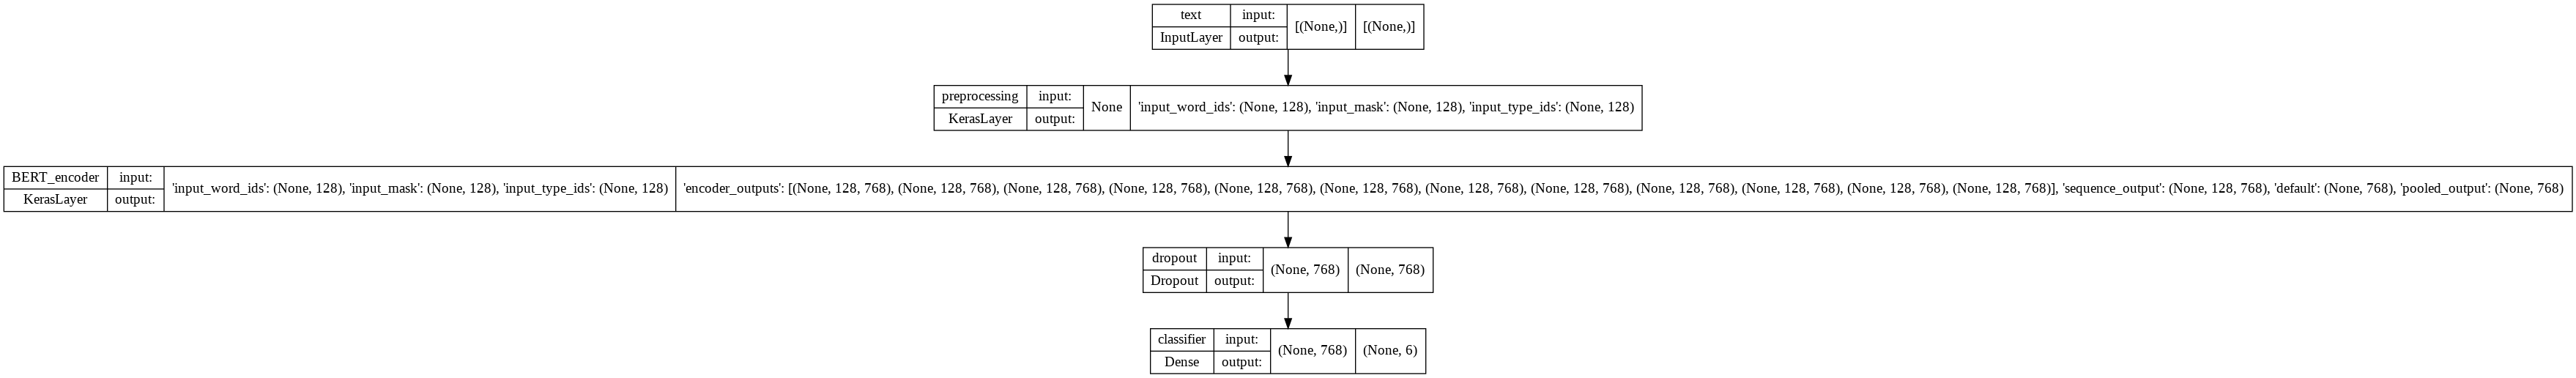

In [33]:
tf.keras.utils.plot_model(classifier_model, "mini_resnet.png", show_shapes=True)


Import the title as df

In [35]:
def BertResult_title(titile_csv,filename):
    #generate the predictive result 
    text_list = titile_csv.columns
    predictiion = classifier_model(tf.constant(text_list))

    # Extraction
    result_for_pred = [f'{class_names[np.argmax(predictiion[i])] }' for i in range(len(predictiion))]
    title = [f'{text_list[i]:<30}'for i in range(len(text_list))]
    pred = pd.DataFrame({"title":title, "predict": result_for_pred})

    # Save path
    default_pwd = '/content/drive/Shareddrives/Text Mining/CSV/Title_pos_neg/'
    path = default_pwd + str(filename)
    with open(path, 'w', encoding = 'utf-8-sig') as f:
      pred.to_csv(f)


def BertResult_content(content_csv,filename):
  # 需要更改
  #generate the predictive result 
  text_list = content_csv.columns
  predictiion = classifier_model(tf.constant(text_list))

  # Extraction
  result_for_pred = [f'{class_names[np.argmax(predictiion[i])] }' for i in range(len(predictiion))]
  title = [f'{text_list[i]:<30}'for i in range(len(text_list))]
  pred = pd.DataFrame({"title":title, "predict": result_for_pred})
  # save path
  default_pwd = '/content/drive/Shareddrives/Text Mining/CSV/Content_pos_neg/'
  path = default_pwd + str(filename)
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    pred.to_csv(f)


### Title Prediction 

In [36]:
import_pwd = '/content/drive/Shareddrives/Text Mining/CSV/Crawler/'

# GUO
name = "output_title_GUO.csv"
input_GUO = pd.read_csv(import_pwd +'GUO_title_output.csv')
BertResult_title(input_GUO,filename = name)

# LEE
name = "output_title_LEE.csv"
input_LEE = pd.read_csv(import_pwd + 'LEE_title_output.csv')
BertResult_title(input_LEE,filename = name)

# LIN
name = "output_title_LIN.csv"
input_LIN = pd.read_csv(import_pwd + 'LIN_title_output.csv')
BertResult_title(input_LIN,filename = name)

# TAI
name = "output_title_TAI.csv"
input_TAI = pd.read_csv(import_pwd + 'TAI_title_output.csv')
BertResult_title(input_TAI,filename = name)

# YANG
name = "output_title_YANG.csv"
input_YANG = pd.read_csv(import_pwd + 'YANG_title_output.csv')
BertResult_title(input_YANG,filename = name)

#### 合併title 資料

此段程式碼是用於產出將BERT五位運動員之預測資料合併成一份CSV資料合併成一份CSV

In [38]:
import os

# 要拼接的文件夾及其完整路徑，注不要包含中文
## 待讀取批量csv的文件夾
read_folder =  "/content/drive/MyDrive/NTHU/TextMining/Text Mining Team Project/CSV/Title_pos_neg"
# 修改當前工作目錄
os.chdir(read_folder)
# 將該文件夾下的所有文件名存入列表
csv_name_list = os.listdir()

data_df = pd.DataFrame()
for i in range(len(csv_name_list)):
  # 讀取第一個CSV文件幷包含表頭，用於後續的csv文件拼接
  df = pd.read_csv( csv_name_list[i],header=None) #不把第一行作列屬性
  df.drop(df.index[0:1], inplace=True) 
  print(f'Current finish the {i}; Name: {csv_name_list[i]} \n')
  
  print("Let's rbind")
  
  data_df = data_df.append(df)


# drop the index 
data_df = data_df.drop(columns=[0])

# reset the column name
data_df.columns = [ 'Title', 'Prediction']


# save as csv
default_pwd = '/content/drive/MyDrive/NTHU/TextMining/Text Mining Team Project/CSV/Title_output_summary/'
path = default_pwd + "output_all_athelete.csv"
with open(path, 'w', encoding = 'utf-8-sig') as f:
  data_df.to_csv(f, index = False)
data_df.head(10)

Current finish the 0; Name: output_title_GUO.csv 

Let's rbind
Current finish the 1; Name: output_title_LEE.csv 

Let's rbind
Current finish the 2; Name: output_title_TAI.csv 

Let's rbind
Current finish the 3; Name: output_title_YANG.csv 

Let's rbind
Current finish the 4; Name: output_title_LIN.csv 

Let's rbind


,Title,Prediction
1,[問卦]歐美中國舉重同量級無法超越台灣郭婞淳？,neg
2,[新聞] 世錦賽》「舉重女神」郭婞淳挺舉、總和,pos
3,[爆卦] 郭婞淳2021舉重世錦賽挺舉&總和金牌,pos
4,[問卦] 郭婞淳國語也太不標準了吧？,neg
5,[問卦] 如果郭婞淳的故事拍電影讓瑤瑤演可以嗎？,pos
6,[新聞] 議員建議為舉重女神郭婞淳設「婞淳路」,pos
7,[問卦] 郭婞淳可以舉起幾c.c. 的機車,neg
8,[新聞] 多次模仿郭婞淳！男星錄影收「存證信函」,neg
9,Re: [問卦] 跟郭婞淳上教練課 一堂多少才合理,neg
10,Re: [問卦] 跟郭婞淳上教練課 一堂多少才合理.1,neg


## content

類似title之處理

In [43]:
import pandas as pd
# import_pwd = '/content/drive/MyDrive/NTHU/TextMining/Text Mining Team Project/CSV/'
import_pwd = '/content/drive/Shareddrives/Text Mining/CSV/Crawler/'

# GUO
name = "content_GUO.csv"
input_GUO = pd.read_csv(import_pwd +'GUO_content_output.csv')
content_csv  = input_GUO


content資料清理

In [46]:
#generate the predictive result 
text_list = content_csv.columns
predictiion = classifier_model(tf.constant(text_list))
predictiion

<tf.Tensor: shape=(100, 6), dtype=float32, numpy=
array([[2.31515057e-03, 9.97509837e-01, 3.14714816e-05, 5.85836169e-05,
        2.26642333e-05, 6.23765081e-05],
       [9.99630809e-01, 2.76354549e-04, 2.43712675e-05, 2.71631798e-05,
        2.23355546e-05, 1.90685550e-05],
       [5.94061278e-02, 9.37955022e-01, 6.63701387e-04, 5.49334858e-04,
        5.86909591e-04, 8.38965178e-04],
       [9.97964621e-01, 1.94660737e-03, 5.41699501e-06, 4.09538006e-05,
        2.48965152e-05, 1.74509896e-05],
       [4.25457984e-01, 5.73423862e-01, 2.80349777e-04, 3.58655234e-04,
        3.63747415e-04, 1.15342926e-04],
       [9.99665499e-01, 2.67768832e-04, 2.04407115e-05, 1.63242876e-05,
        1.95112480e-05, 1.04230121e-05],
       [1.78638827e-02, 9.81424034e-01, 1.27701132e-04, 1.71788226e-04,
        2.05868855e-04, 2.06780271e-04],
       [9.58245754e-01, 3.92262973e-02, 7.91457191e-04, 3.21902597e-04,
        6.21896121e-04, 7.92702136e-04],
       [9.94695961e-01, 5.18388348e-03, 2.6531

In [47]:
# Extraction
result_for_pred = [f'{class_names[np.argmax(predictiion[i])] }' for i in range(len(predictiion))]
title = [f'{text_list[i]:<30}'for i in range(len(text_list))]
pred = pd.DataFrame({"title":title, "predict": result_for_pred})

pred

,title,predict
0,\n郭婞淳又再次拿到世錦賽金牌了\n\n舉重算是世界熱門項目，\n\n中國跟歐美體育強國為什...,pos
1,\n備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\n※ 例如蘋果日報、自由時報（請...,neg
2,\n2020東京奧運舉重金牌得主郭婞淳\n\n於2021年世界舉重錦標賽的女子59公斤級\n...,pos
3,\n如題\n\n現在體育選手廣告很多\n\n郭婞淳有個廣告講比較多話\n\n國語超不標準耶\...,neg
4,\n郭婞淳在台灣的歷史地位無庸置疑\n\n再加上她的人生也很戲劇性\n\n根本就可以拍成電影...,pos
...,...,...
95,\n備註請放最後面 違者新聞文章刪除\n\n1.媒體來源:\nYahoo\n\n\n2.記者...,neg
96,\n1.媒體來源:\n\n中時\n\n2.記者署名:\n\n07:112021/07/28 ...,neg
97,\n本佛納悶\n\n甚麼女權甲權余祥拳其實哀洞凱爾\n\n只要有一點點血性的正常人\n\n台...,neg
98,\nnewtalk\n\n新頭殼newtalk | 陳佩君 台北市報導\n\n把郭婞淳寫成陳...,neg


In [42]:

# save path
# default_pwd = '/content/drive/MyDrive/NTHU/TextMining/Text Mining Team Project/CSV/Content_pos_neg/'
# path = default_pwd + str(filename)
# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   pred.to_csv(f)

# # LEE
# name = "content_title_LEE.csv"
# input_LEE = pd.read_csv(import_pwd + 'LEE_comments_output.csv')
# BertResult_content(input_LEE,filename = name)

# # LIN
# name = "content_title_LIN.csv"
# input_LIN = pd.read_csv(import_pwd + 'LIN_comments_output.csv')
# BertResult_content(input_LIN,filename = name)

# # TAI
# name = "content_title_TAI.csv"
# input_TAI = pd.read_csv(import_pwd + 'TAI_comments_output.csv')
# BertResult_content(input_TAI,filename = name)

# # YANG
# name = "content_title_YANG.csv"
# input_YANG = pd.read_csv(import_pwd + 'YANG_comments_output.csv')
# BertResult_content(input_YANG,filename = name)

NameError: ignored

### 合併content資料

In [ ]:
# import os
# # 要拼接的文件夾及其完整路徑，注不要包含中文
# ## 待讀取批量csv的文件夾

# read_folder =  "/content/drive/MyDrive/Text Mining Team Project/CSV/Content_pos_neg"
# # 修改當前工作目錄
# os.chdir(read_folder)
# # 將該文件夾下的所有文件名存入列表
# csv_name_list = os.listdir()

# csv_name_list

# data_df = pd.DataFrame()
# for i in range(len(csv_name_list)):
#   # 讀取第一個CSV文件幷包含表頭，用於後續的csv文件拼接
#   df = pd.read_csv( csv_name_list[i],header=None) #不把第一行作列屬性
#   df.drop(df.index[0:1], inplace=True) 
#   print(f'Current finish the {i}; Name: {csv_name_list[i]} \n')
  
#   print("Let's rbind")
  
#   data_df = data_df.append(df)


# # drop the index 
# data_df = data_df.drop(columns=[0])

# # reset the column name
# data_df.columns = [ 'Content', 'Prediction']


# # save as csv
# default_pwd = '/content/drive/MyDrive/Text Mining Team Project/CSV/content_output_summary'
# path = default_pwd + "output_all_content.csv"
# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   data_df.to_csv(f, index = False)
# data_df.head(10)

## 純文字檔test

In [ ]:
# text_1 = ["黑人老兄受不了老媽一直偷吃他的雞肉，拿起光劍去找老媽輸贏"]
# example_result = classifier_model(tf.constant(text_1))

# print_my_examples(text_1,example_result)